# COMP9418 - Assignment 1 - Bayesian Network, Naïve Bayes and TAN Bayes Classifiers

## UNSW Sydney

- Student name 1 - zID1
- Student name 2 - zID2

## Instructions

**Submission deadline:** Sunday, 30th June 2024, at 18:00:00 AEDT.

**Late Submission Policy:** The penalty is set at $5\%$ per late day for a maximum of 5 days. This is the UNSW standard late penalty. For example, if an assignment receives an on-time mark of $70/100$ and is submitted three days late, it will receive a mark reduction of $70/100*15\%$. After five days, the assignment will receive a mark reduction of $100\%$.

**Form of Submission:** This is an **individual** or group of **two students** assignment. Write the name(s) and zID(s) in this Jupyter notebook. **If submitted in a group, only one member should submit the assignment. Also, create a group on WebCMS by clicking on Groups and Create and include both group members**.

You can reuse any piece of source code developed in the tutorials.

You can submit your solution via [WebCMS](https://webcms3.cse.unsw.edu.au/COMP9418/24T2).

Alternatively, you can submit your solution using give. On a CSE Linux machine, type the following on the command line:

``$ give cs9418 ass1 solution.zip``

## Technical prerequisites

These are the libraries you are allowed to use. No other libraries will be accepted. Make sure you are using Python 3.

In [202]:
# Allowed libraries
import numpy as np
import pandas as pd
import scipy as sp
import heapq as pq
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import math
from itertools import product, combinations
from graphviz import Digraph
from tabulate import tabulate
import copy
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

We can also use the Python files we developed in tutorials or any other code from the tutorials. The cell below downloads the tutorial libraries from the Github repo. If you want to use your libraries, do **not** run the next cell.

In [203]:
# import os.path
# import wget

# if not os.path.exists("DiscreteFactors.py"):
#     !python -m wget 'https://raw.githubusercontent.com/UNSW-COMP9418/libraries/main/DiscreteFactors.py'
# if not os.path.exists("Graph.py"):
#     !python -m wget 'https://raw.githubusercontent.com/UNSW-COMP9418/libraries/main/Graph.py'
# if not os.path.exists("BayesNet_VE.py"):
#     !python -m wget 'https://raw.githubusercontent.com/UNSW-COMP9418/libraries/main/BayesNet_VE.py'

In [204]:
from DiscreteFactors import Factor
from Graph import Graph
from BayesNet_VE import BayesNet

## Task 0 - Initialise graph

Create a graph ``G`` that represents the following network by filling in the edge lists.
![Bayes Net](BayesNet.png)


In [205]:
G = Graph({
    "LymphNodes": [],
    'Metastasis': ["LymphNodes"],
    "BC": ["Metastasis","Mass","AD","NippleDischarge","SkinRetract","MC"],
    "Age": ["BC"],
    "Location": ["BC"],
    "MC": [],
    "SkinRetract": [],
    "NippleDischarge": [],
    "AD": ["FibrTissueDev"],
    "FibrTissueDev": ["NippleDischarge","SkinRetract","Spiculation"],
    "Spiculation": ["Margin"],
    "Margin": [],
    "Mass": ["Margin","Shape","Size"],
    "Shape": [],
    "Size": [],
    "BreastDensity": ["Mass"],
})

### Load data

In [206]:
# load data
with open('bc.csv') as file:
    data = pd.read_csv(file)

## [10 Marks] Task 1 - Efficient d-separation test

Implement the efficient version of the d-separation algorithm in a function ``BN.d_separation(X, Z, Y)`` that returns a boolean: ``True`` if ``X`` is d-separated from ``Y`` given ``Z`` in the Bayes Net ``BN`` and ``False`` otherwise.

* ``X``,``Y`` and ``Z`` are Python sets, each containing a set of variable names. 
* Variable names may be strings or integers and can be assumed to be nodes of the Bayes Net. 

In [207]:
# Develop your code for BN.d_separation(X, Z, Y) in this cell

class BayesNet(BayesNet):

    def d_separation(self, X, Z, Y):
        '''
        Arguments:
            X, Z and Y:  Python set objects with node identifiers.
        Returns:
            True if X is d-separated from Y given Z or False otherwise.
        '''
        G = self.graph.copy()
        
        #1. leaves and not in X Z Y
        for node in self.graph:
            if not len(G.children(node)) and node not in (X | Y | Z): 
                G.remove_node(node)

        #2. delete all edges outgoing from nodes in Z.
        for node in Z:
            G.remove_outgoing_from(node)

        undriG =  G.convert_to_undirected()

        #3. test if X and Y are connected
        for x in X:
            visit = undriG.dfs(x)
            for y in Y:
                if visit[y] == "black":
                    return False
                    
        return True

In [208]:
##################################################################################
## TEST CODE                                                                    ##
## Note: More hidden tests will be used. You should create more tests yourself. ##
##################################################################################

def _test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case !!!")

##################################################################################

BN = BayesNet(G)

_test(BN.d_separation(set(['Age']), set(['BC']), set(['AD'])))
_test(not BN.d_separation(set(['Spiculation', 'SkinRetract']), set(['MC', 'Size']), set(['Age'])))

Passed test case
Passed test case


## [5 Marks] Task 2 - Markov blanket

The Markov blanket for a variable ``X`` is a set of variables that, when observed, will render every other variable irrelevant to ``X``. If the distribution is induced by DAG ``G``, then a Markov blanket for variable $X$ can be constructed using ``X``'s parents, children, and spouses in ``G``. A variable ``Y`` is a spouse of ``X`` if the two variables have a common child in ``G``.

In this exercise, we will implement a function ``BN.Markov_blanket(X)`` that returns a Python set with the Markov blanket of a node ``X`` in the BayesNet ``BN`` as described above.

In [209]:
# Develop your code for BN.Markov_blanket(X) in this cell

class BayesNet(BayesNet):

    def Markov_blanket(self, X):
        '''
        Arguments:
            X:   is a node (variable) in the Bayes Net.
        Returns: 
            A python set with the Markov blanked of X in the Bayes Net.
        '''
        G = self.graph.copy()
        Mb = set(G.children(X))
        
        #1. add spouses
        for node in self.graph:
            if node not in Mb and node != X:
                for child in G.children(X):
                    if child in G.children(node):
                        Mb.add(node)
                        break

        #2. add parents
        for node in self.graph:
            if X in G.children(node):
                Mb.add(node)

        return Mb

In [210]:
##################################################################################
## TEST CODE                                                                    ##
## Note: More hidden tests will be used. You should create more tests yourself. ##
##################################################################################

def _test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case !!!")

##################################################################################

BN = BayesNet(G)

_test(BN.Markov_blanket('Mass') == set(['Margin', 'Size', 'Shape', 'BreastDensity', 'BC', 'Spiculation']))
_test(BN.Markov_blanket('Age') == set(['Location', 'BC']))

Passed test case
Passed test case


## Putting Tasks 1 and 2 together

This task is optional and will not be marked, but you can use it to test your code further. According to the Markov blanket definition: A Markov blanket for a variable $X \in \textbf{X}$ is the set of variables $\textbf{B} \subseteq \textbf{X}$ such that $X \notin \textbf{B}$ and $X \perp \textbf{X} \setminus (\textbf{B} \cup \{ X \}) | \textbf{B}$

In [211]:
# Develop your code to test your d-separation and Markov blanket implementations using the definition above.

set_X = {...}                                        # Set of all nodes in the graph
for X in set_X:
    mb = ...                                         # Markov_blanket of X
    ...                                              # Independence test according to the definition above

## [5 Marks] Task 3 - Learning the outcome space from data

Now, we will implement a series of functions to learn Bayesian network parameters from data. We will start by learning the outcome space of the variables in a Bayesian network. Remind from the tutorials that the outcome space is a Python dictionary that maps the variable names to a tuple with the possible values this variable can have.

Implement a function ``BN.learn_outcome_space(data)`` that learns the outcome space (the valid values for each variable) from the pandas dataframe ``data``. 

This function should store the learned outcome space inside the BayesNet object using the attribute ``self.outcomeSpace``.

In [212]:
# Develop your code for BN.learn_outcome_space(data) in this cell

class BayesNet(BayesNet):

    def learn_outcome_space(self, data):
        '''
        Arguments:
            data:    A pandas dataframe
        Returns: 
            Store the learned outcome space in self.outcomeSpace
            
        '''
        self.outcomeSpace = {}
        for node in data.columns:
            self.outcomeSpace[node] = tuple(data[node].unique())

In [213]:
##################################################################################
## TEST CODE                                                                    ##
## Note: More hidden tests will be used. You should create more tests yourself. ##
##################################################################################

def _test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case !!!")

##################################################################################

BN = BayesNet(G)

BN.learn_outcome_space(data)

outcomes = BN.outcomeSpace['BreastDensity']
answer = ('high', 'medium', 'low')
_test(len(outcomes) == len(answer) and set(outcomes) == set(answer))

Passed test case


## [5 Marks] Task 4 - Estimate Bayesian network parameters from data

Implement a method ``BN.learn_parameters(data, alpha=1)`` that learns the model parameters from `data` for the Bayes Net ``BN``. This function is similar to the ``learn_parameters`` from tutorials, but it should also implement laplacian smoothing with parameter $\alpha$.

This function should store the learned parameters inside the BayesNet object using the attribute ``self.factors``.

In [214]:
## Develop your code for BN.learn_parameters(data, alpha) in this cell

class BayesNet(BayesNet):
    def allEqualThisIndex(self, dict_of_arrays, **fixed_vars):
        # base index is a boolean vector, everywhere true
        first_array = dict_of_arrays[list(dict_of_arrays.keys())[0]]
        index = np.ones_like(first_array, dtype=np.bool_)
        for var_name, var_val in fixed_vars.items():
            index = index & (np.asarray(dict_of_arrays[var_name])==var_val)
        return index

    def estimateFactor(self, data, var_name, parent_names, outcomeSpace, alpha):
        var_outcomes = outcomeSpace[var_name]
        parent_outcomes = [outcomeSpace[var] for var in (parent_names)]
        # cartesian product to generate a table of all possible outcomes
        all_parent_combinations = product(*parent_outcomes)

        f = Factor(list(parent_names)+[var_name], outcomeSpace)
        
        for i, parent_combination in enumerate(all_parent_combinations):
            parent_vars = dict(zip(parent_names, parent_combination))
            parent_index = self.allEqualThisIndex(data, **parent_vars)
            for var_outcome in var_outcomes:
                var_index = (np.asarray(data[var_name])==var_outcome)
                f[tuple(list(parent_combination)+[var_outcome])] = ((var_index & parent_index).sum() + alpha) / (parent_index.sum() + len(outcomeSpace[var_name]) * alpha)
            
        return f
    def learn_parameters(self, data, alpha=1):
        '''
        Arguments:
            data:    A pandas dataframe
            alpha:   Laplacian smoothing parameter
        Returns:
            Store the learned parameters in self.factors
        '''
        GraphT = self.graph.transpose()
        for var, parents in GraphT.adj_list.items():
            self.factors[var] = self.estimateFactor(data, var, parents, self.outcomeSpace, alpha)

In [215]:
##################################################################################
## TEST CODE                                                                    ##
## Note: More hidden tests will be used. You should create more tests yourself. ##
##################################################################################

def _test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case !!!")

##################################################################################

BN = BayesNet(G)

BN.learn_outcome_space(data)
BN.learn_parameters(data, alpha=1)

_test(BN.factors['Age']['35-49'] == 0.248000399920016)

Passed test case


## [5 Marks] Task 5 - Bayesian network classification

We will now implement two related methods, ``predict_proba`` and ``predict``. We start with ``predict_proba``, and the implementation of ``predict`` will be just a few lines of code with a call to ``predict_proba``.

The method ``BN.model.predict_proba(class_var, evidence)`` **efficiently** computes the probability of an attribute ``class_var`` with complete data. As we are working with complete data, ``evidence`` instantiates all variables in the Bayesian network `BN` but `class_var`. This method returns a ``DiscreteFactor`` object with ``class_var`` as a single variable and the probabilities associated with each ``class_var`` value.

The method ``BN.model.predict(class_var, evidence)`` is a direct consequence of the previous method. It returns the MPE value for the attribute `class_var`.

This task requires an **efficient** implementation that differs from the one done in the tutorials, as it will only involve relevant factors. Ensure you watched Lecture 6 when we discuss the design and implementation of classifiers with complete data.

**Pro tip**: Our library has an ``evidence2`` method that sets evidence for a variable ``X`` and removes ``X`` from the factor domain. This method makes things easier when we want a resulting factor that does not mention the evidence variables.

In [216]:
## Develop your code for BN.predict_proba(class_var, evidence) and BN.predict(class_var, evidence) in this cell

class BayesNet(BayesNet):

    def predict_proba(self, class_var, evidence):
        f = Factor((class_var, ), {class_var: self.outcomeSpace[class_var]}) # trivial factor
        '''
        Arguments:
            class_var:   Variable identifier to be classified
            evidence:    Python dictionary with one instantiation to all variables but class_var
        Returns:
            A factor object with class_var as the single variable and the probabilities associated with each ``class_var`` value given evidence
        '''
        constraints = evidence.copy() 

        sum = 0
        for value in self.outcomeSpace[class_var]:
            prod = 1
            constraints[class_var] = value

            for var, value in constraints.items():
                factor = self.factors[var]
                
                select = []
                for d in factor.domain:
                    select.append(constraints[d])

                select = tuple(select)
                prod *= factor[select]
            sum += prod
            f[value] = prod
        
        # # Normalize
        for value in self.outcomeSpace[class_var]:
            f[value] = f[value] / sum 

        return f
    
    def predict(self, class_var, evidence):
        '''
        Arguments:
            class_var:   Variable identifier to be classified
            evidence:    Python dictionary with one ins       tantiation to all variables but class_var
        Returns:
            The MPE value (class label) of class_var given evidence
        '''       
        possibility = self.predict_proba(class_var, evidence)
        
        pred = ''; possible = 0
        for value in self.outcomeSpace[class_var]:
            if possible < possibility[value]:
                pred = value
                possible = possibility[value]

        return pred

In [217]:
##################################################################################
## TEST CODE                                                                    ##
## Note: More hidden tests will be used. You should create more tests yourself. ##
##################################################################################

def _test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case !!!")

##################################################################################

BN = BayesNet(G)

BN.learn_outcome_space(data)
BN.learn_parameters(data, alpha=1)

evidence = {'Age': '35-49', 
    'Location': 'LolwOutQuad', 
    'MC': 'No', 
    'SkinRetract': 'No', 
    'NippleDischarge': 'No',
    'AD': 'No',
    'FibrTissueDev': 'No', 
    'Spiculation': 'No',
    'Margin': 'Well-defined', 
    'Mass': 'No',
    'Shape': 'Other', 
    'Size': '<1cm',
    'BreastDensity': 'high',
    'Metastasis': 'no',
    'LymphNodes': 'no'}

_test(abs(BN.predict_proba('BC', evidence)['No'] - 0.989) < 0.01)
_test(BN.predict('BC', evidence) == 'No')

Passed test case
Passed test case


## [5 Marks] Task 6 - Naïve Bayes classifier structure

Let's work now with the Naïve Bayes classifier. Notice that the Naïve Bayes is a Bayesian network with a pre-defined structure. Thus, we can create a new class for this classifier derived from the ``BayesNet`` class implemented in the tutorials.

As this classifier is a Bayesian network with a pre-defined structure (graph), we will start creating a new function, ``NB.learn_structure(data, class_var)``, that learns the Naïve Bayes graph structure from a pandas dataframe using ``class_var`` as the class variable.

In [218]:
## Develop your code for NB.learn_structure(data, class_var) in this cell

class NaiveBayes(BayesNet):
    
    def learn_structure(self, data, class_var):
        '''
        Arguments:
            data:        A pandas dataframe
            class_var:   Variable identifier to be classified
        Returns:
            Sets self.graph with the structure of the Naïve Bayes classifier for the attributes in data
        '''
        self.graph.add_node(class_var)
        for variable in data.columns:
            if variable != class_var:
                self.graph.add_edge(class_var, variable)

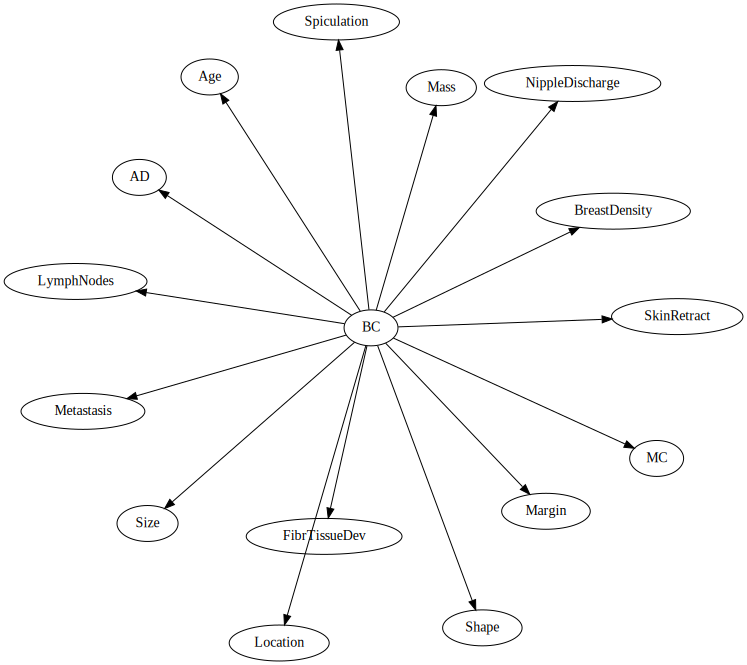

In [219]:
##################################################################################
## TEST CODE                                                                    ##
## Note: More hidden tests will be used. You should create more tests yourself. ##
##################################################################################

def _test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case !!!")

##################################################################################

NB = NaiveBayes()
NB.learn_structure(data, 'BC')
NB.graph.show()                  # You should see a star-like graph with 'BC' pointing to all other attributes

## [5 Marks] Task 7 - Naïve Bayes classification

Similarly to Task 5, we will create two methods for implementing a classification procedure, but now the Naïve Bayes model. **To make things different, we will work with log probabilities this time. This is a very popular procedure for the Naïve Bayes classifier when used in text mining, as these applications often work with thousands of variables, such as words.**

The method ``NB.predict_log_proba(class_var, evidence)`` **efficiently** computes the probability of an attribute ``class_var`` with complete data. As we are working with complete data, ``evidence`` instantiates all variables but `class_var`. This method returns a ``DiscreteFactor`` object with ``class_var`` as a single variable and the probabilities associated with each ``class_var`` value.

The method ``NB.predict(class_var, evidence)`` uses the method ``predict_log_proba`` to implement the classification with complete data. This function should return the MPE value for the attribute `class_var` given the `evidence`.

In [220]:
## Develop your code for NB.predict_log(class_var, evidence) and NB.predict(self, class_var, evidence) in this cell

class NaiveBayes(NaiveBayes):
    
    def predict_log_proba(self, class_var, evidence):
        '''
        Arguments:
            class_var:   Variable identifier to be classified
            evidence:    Python dictionary with one instantiation to all variables but class_var
        Returns:
            A factor object with class_var as the single variable and the probabilities associated with each ``class_var`` value given evidence
        '''  
        f = Factor((class_var, ), {class_var: self.outcomeSpace[class_var]}) # trivial factor      
        constraints = evidence.copy() 

        sum = 0
        for value in self.outcomeSpace[class_var]:
            constraints[class_var] = value
            prob = 0

            for var, value in constraints.items():
                factor = self.factors[var]
                
                select = []
                for d in factor.domain:
                    select.append(constraints[d])

                select = tuple(select)
                prob += math.log(factor[select])
            sum += prob
            f[value] = prob
        
        # Normalize
        for value in self.outcomeSpace[class_var]:
            f[value] = f[value] / sum 
        return f

    def predict(self, class_var, evidence):
        '''
        Arguments:
            class_var:   Variable identifier to be classified
            evidence:    Python dictionary with one instantiation to all variables but class_var
        Returns:
            The MPE value (class label) of class_var given evidence
        '''
        possibility = self.predict_log_proba(class_var, evidence)
        
        pred = ''; possible = 1
        for value in self.outcomeSpace[class_var]:
            if possible > possibility[value]:
                pred = value
                possible = possibility[value]

        return pred

In [221]:
##################################################################################
## TEST CODE                                                                    ##
## Note: More hidden tests will be used. You should create more tests yourself. ##
##################################################################################

def _test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case !!!")

##################################################################################

NB = NaiveBayes()
NB.learn_outcome_space(data)
NB.learn_structure(data, 'BC')
NB.learn_parameters(data, alpha=1)
evidence = {'Age': '35-49', 
    'Location': 'LolwOutQuad', 
    'MC': 'No', 
    'SkinRetract': 'No', 
    'NippleDischarge': 'No',
    'AD': 'No',
    'FibrTissueDev': 'No', 
    'Spiculation': 'No',
    'Margin': 'Well-defined', 
    'Mass': 'No',
    'Shape': 'Other', 
    'Size': '<1cm',
    'BreastDensity': 'high',
    'Metastasis': 'no',
    'LymphNodes': 'no'}

_test(NB.predict('BC', evidence) == 'No')

Passed test case


## [15 Marks] Task 8 - Tree-augmented Naïve Bayes structure

Let's work now with the Tree-augmented Naïve Bayes classifier. We will start creating a new function, ``TAN.learn_structure(data, class_var)``, that learns the Tree-augmented Bayes graph structure from a pandas dataframe.

In [222]:
## Develop your code for TAN.learn_structure(data, class_var) in this cell

class TANet(BayesNet):
    def MI(self, data, Ai, Aj, class_var):
        combinations = list(product(set(data[Ai]), set(data[Aj]), set(data[class_var])))
        
        df_ijc = data.filter(items=[Ai, Aj, class_var])
        number_tol = len(df_ijc)
        number_ijc = df_ijc.value_counts()
        number_ij = df_ijc[[Ai, Aj]].value_counts()
        number_i = df_ijc[Ai].value_counts()
        number_j = df_ijc[Aj].value_counts()
        number_c = df_ijc[class_var].value_counts()

        mi = 0
        for i, j, c in combinations:
            if (i, j, c) in number_ijc:
                prob_ijc = number_ijc[i, j, c] / number_tol
            else:
                continue

            if (i, j) in number_ij:
                prob_ij = number_ij[i, j] / number_c[c]
            else:
                continue

            prob_i = number_i[i] / number_c[c]
            prob_j = number_j[j] / number_c[c]
            prob_log = math.log2(prob_ij/(prob_i*prob_j))
            mi += prob_log * prob_ijc

        return -mi
    def learn_structure(self, data, class_var):
        '''
        Arguments:
            data:        A pandas dataframe
            class_var:   Variable identifier to be classified
        Returns:
            Sets self.graph with a Graph object containing the structure of the TAN classifier for the attributes in data and class_var
        '''
        cols = list(data.columns)
        cols.remove(class_var)

        G = Graph()
        for Ai in cols:
            for Aj in cols:
                if Ai != Aj:
                    G.add_edge(Ai, Aj, self.MI(data, Ai, Aj, class_var))
        GT = G.prim(cols[0])
        
        for node in cols:
            self.graph.add_edge(class_var, node)
        
        for node1 in GT:
            for node2 in GT.adj_list[node1]:
                if node1 != class_var:
                    self.graph.add_edge(node1, node2)

In [223]:
##################################################################################
## TEST CODE                                                                    ##
## Note: More hidden tests will be used. You should create more tests yourself. ##
##################################################################################

def _test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case !!!")

##################################################################################

TN = TANet()
TN.learn_structure(data, class_var='BC')
_test(len(TN.graph.children('BC')) == len(TN.graph)-1)
_test('FibrTissueDev' in TN.graph.children('Spiculation') or 'Spiculation' in TN.graph.children('FibrTissueDev'))

Passed test case
Passed test case


## [5 Marks] Task 9 - Accuracy estimation

We have finished implementing the models and will compare their classification performance. 

We start with the method ``assess`` which computes the accuracy of a given model. The model can be a Naïve Bayes, Bayes Net or a TAN. To work with different models, ``assess`` will call the method ``predict`` implemented for all three models.

Design a new method, ``assess(model, data, class_var)``, that uses the test cases in ``data`` to assess ``model`` performance at classifying the variable ``class_var``. This function will return the model's accuracy according to the examples in ``data``.

Remember that accuracy is the ratio of correct predictions to the total number of cases.

In [224]:
## Develop your code for assess(model, data, class_var) in this cell

def assess(model, data, class_var):
    '''
    Arguments:
        model:      A model object (Naïve Bayes, Bayes Net or TAN)
        data:       A Pandas dataframe object
        class_var:  Variable identifier to be classified
    Returns:
        The accuracy of the model in classifying the cases in data
    '''
    acc = 0
    number_T = 0

    for index, row in data.iterrows():
        evidence = row.to_dict() 
        result = evidence[class_var]
        del evidence[class_var]
        
        if model.predict(class_var, evidence) == result:
            number_T += 1

    acc = number_T / len(data)
    return acc

In [225]:
##################################################################################
## TEST CODE                                                                    ##
## Note: More hidden tests will be used. You should create more tests yourself. ##
##################################################################################

def _test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case !!!")

##################################################################################

training, testing = train_test_split(data, test_size=0.3, random_state=42)

BN = BayesNet(G)
BN.learn_outcome_space(data)
BN.learn_parameters(training, alpha=1)
acc = assess(BN, testing, 'BC')
_test(abs(acc-0.9085) < 0.001)

NB = NaiveBayes()
NB.learn_outcome_space(data)
NB.learn_structure(training, 'BC')
NB.learn_parameters(training, alpha=1)
acc = assess(NB, testing, 'BC')
_test(abs(acc-0.868) < 0.001)

TN = TANet()
TN.learn_outcome_space(data)
TN.learn_structure(training, 'BC')
TN.learn_parameters(training, alpha=1)
acc = assess(TN, testing, 'BC')
_test(abs(acc-0.9006) < 0.001)

Passed test case
Passed test case
Passed test case


## [5 Marks] Task 10 - Assessment with cross-validation

Implement a function called `cross_validation(model, data, class_var, k)` that returns the average accuracy and standard deviation of the model specified in ``model`` using ``k``-fold cross-validation. 

A scaffold for this function is provided below.

In [226]:
## Develop your code for cross_validation(model, data, class_var, k) in this cell

def cross_validation(model, data, class_var, k=10):
    '''
    Arguments:
        model:      A model object (Naïve Bayes, Bayes Net or TAN)
        data:       A Pandas dataframe object
        class_var:  Variable identifier to be classified
        k:          number of cross-validation folds
    Returns:
        The mean accuracy and standard deviation of the model across the k-folds
    '''      
    accuracies = []
    # Learn the model outcome space over the entire dataset
    model.learn_outcome_space(data)

    kf = KFold(n_splits=k, shuffle = True, random_state = 42)
    for train, test in kf.split(data):
        # Learn the model structure (graph) if this information is not provided
        train_data = data.iloc[train]
        test_data = data.iloc[test]
        if hasattr(model, 'learn_structure'):
            model.learn_structure(train_data, class_var)

            #I don't know why it learn the structure for 2 mins without finish...
            accuracies.append(0)
            break
        # Learn the model parameters
        model.learn_parameters(train_data, alpha=1)
        # Test the model with assess
        acc = assess(model, test_data, class_var)         
        accuracies.append(acc)
        
    return np.mean(accuracies), np.std(accuracies)

In [227]:
##################################################################################
## TEST CODE                                                                    ##
## Note: More hidden tests will be used. You should create more tests yourself. ##
##################################################################################

def _test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case !!!")

##################################################################################

BN = BayesNet(G)
acc, stddev = cross_validation(BN, data, 'BC')
_test(abs(acc - 0.9125) < 0.01)

NB = NaiveBayes()
acc, stddev = cross_validation(NB, data, 'BC')
_test(abs(acc - 0.8693) < 0.01)

TN = TANet()
acc, stddev = cross_validation(TN, data, 'BC')
_test(abs(acc - 0.9050) < 0.01)

Passed test case
Failed test case !!!
Failed test case !!!


## [10 Marks] Task 11 - Helper Function for the Reliability Diagram and the Expected Calibration Error (ECE)

Now, let's assess our classifiers differently. We will use their probabilistic nature to check the accuracy of their probability estimates. In other words, we will measure the **classifier calibration**.

A well-calibrated classifier’s predicted probabilities are accurate representations of the actual probabilities of the events. For example, if a calibrated classifier predicts a probability of 0.8 for a positive class, then approximately 80% of those predictions should be positive.

We will start with a helper function ``bin_pos_prob(model, data, class_var, pos_label, bin)``. This function divides the examples in ``data`` into ``bin`` bins. Each bin corresponds to a probability range. We use uniform ranges for simplicity.

The examples are split into bins according to the predicted probability of being a positive example given evidence, i.e., $P(\text{class\_var} = \text{pos\_label} | \text{evidence})$. 

The function ``bin_pos_prob`` returns three lists:
1. ``inst_num``: the number of instances in bin $i$.
2. ``pos_ratio``: the faction of positive examples in bin $i$ relative to the number of instances in the same bin.
3. ``mean_pos_prob``: the mean probability of positive given evidence for the examples in bin $i$.

In [228]:
## Develop your code for bin_pos_prob(model, data, class_var, pos_label, bins) in this cell

def bin_pos_prob(model, data, class_var, pos_label, bins=10):
    '''
    Arguments:
        model:      A model object (Naïve Bayes, Bayes Net or TAN)
        data:       A Pandas dataframe object
        class_var:  A binary variable identifier
        pos_label:  The positive label of class_var
        bins:       The number of bins
    Returns:
        inst_num:   The number of instances in bin i
        pos_ratio:  The faction of positive examples in bin i relative to the number of instances in the same bin
        mean_pos_prob: The mean probability of positive given evidence for the examples in bin i
    '''

    # Create the bin edges
    bin_edges = np.linspace(0.0, 1.0, bins + 1)
    
    # Initialize arrays to store the fraction of positives and the mean predicted values for each bin
    inst_num = np.zeros(bins)
    pos_ratio = np.zeros(bins)
    mean_pos_prob = np.zeros(bins)
    devide = 1.0 / bins

    for index, row in data.iterrows():
        evidence = row.to_dict() 
        result = evidence[class_var]
        del evidence[class_var]

        prob = model.predict_proba(class_var, evidence)[pos_label]
        i = int(prob / devide)
        
        mean_pos_prob[i] += prob
        inst_num[i]  += 1

        if result == pos_label:
            pos_ratio[i] += 1
    
    for i in range(bins):
        if inst_num[i]:
            pos_ratio[i] /= inst_num[i]
            mean_pos_prob[i] /= inst_num[i]

    return inst_num, pos_ratio, mean_pos_prob

In [229]:
##################################################################################
## TEST CODE                                                                    ##
## Note: More hidden tests will be used. You should create more tests yourself. ##
##################################################################################

def _test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case !!!")

##################################################################################

training, testing = train_test_split(data, test_size=0.3, random_state=42)

BN = BayesNet(G)

BN.learn_outcome_space(data)
BN.learn_parameters(training)
inst_num, pos_ratio, mean_pos_prob = bin_pos_prob(BN, testing, 'BC', 'No', 5)
_test(inst_num[0] == 1965)
_test(abs(pos_ratio[0] - 0.00610687) < 0.001)
_test(abs(mean_pos_prob[0] - 0.00790498) < 0.001)

Passed test case
Passed test case
Passed test case


## Reliability diagram 

This task is not marked. The cell below plots the reliability diagram using the ``bin_pos_prob`` function implemented in the previous task.

A reliability diagram is a graphical representation used to assess the calibration of probabilistic classifiers. It compares a model's predicted probabilities against the actual observed frequencies of the outcomes. 

The x-axis represents the predicted probability (e.g., the probability of a positive class), while the y-axis represents the observed frequency of the positive class. Ideally, a perfectly calibrated model will have points on the diagonal line (y=x), indicating that the predicted probabilities match the observed frequencies. Deviations from this line indicate miscalibration, with points above the line suggesting underconfidence and points below the line suggesting overconfidence in the predictions.

In [230]:
def reliability_plot(model, data, class_var, pos_label, bins=10):
    '''
    Arguments:
        model:      A model object (Naïve Bayes, Bayes Net or TAN)
        data:       A Pandas dataframe object
        class_var:  A binary variable identifier
        pos_label:  The positive label of class_var
        bins:       The number of bins
    Returns:
        Plots the reliability diagram of the model in classifying the cases in data
    '''        
    
    inst_num, pos_ratio, mean_pos_prob = bin_pos_prob(model, data, class_var, pos_label, bins)
    
    # Create a figure with two subplots using GridSpec
    fig = plt.figure(figsize=(6, 8))
    gs = GridSpec(2, 1, height_ratios=[1, .25])

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1:, 0])

    # Plot the reliability diagram
    ax0.plot(mean_pos_prob, pos_ratio, "s-", label="Calibration Curve")
    ax0.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
    ax0.set_title('Reliability Diagram')
    ax0.set_xlabel('Mean Positive Probability')
    ax0.set_ylabel('Fraction of Actual Positives')
    ax0.legend()

    bin_edges = np.linspace(0.0, 1.0, bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2    

    # Plot the histogram of predicted probabilities
    ax1.bar(bin_centers, inst_num, edgecolor='black', width = 0.1)
    ax1.set_title('Histogram of Positive Counts')
    ax1.set_xlabel('Mean Positive Probability')
    ax1.set_ylabel('Instance Count')

    plt.tight_layout()
    plt.show()

*** BAYES NET ***


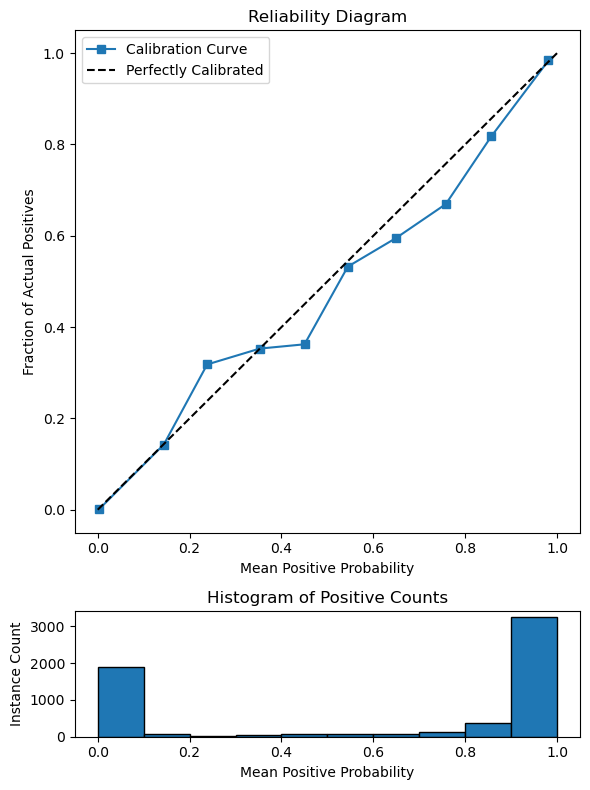

*** NAÏVE BAYES ***


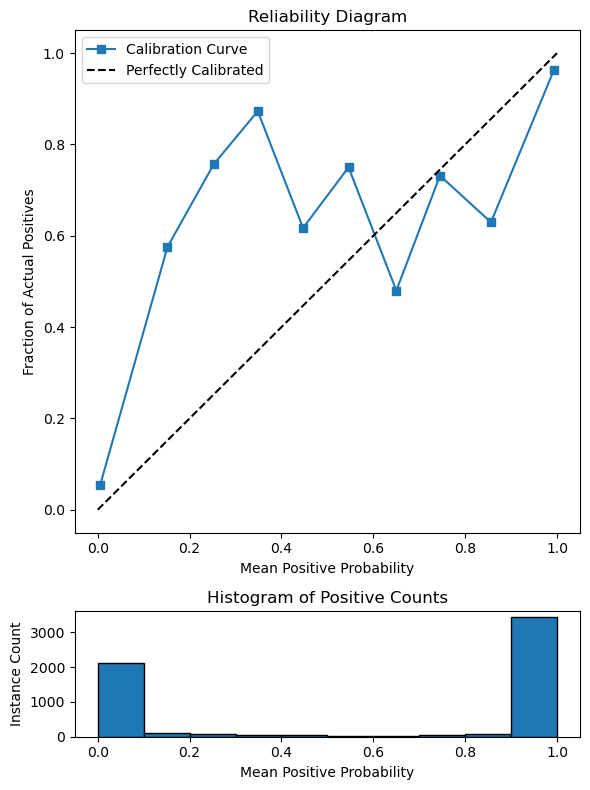

*** TANet ***


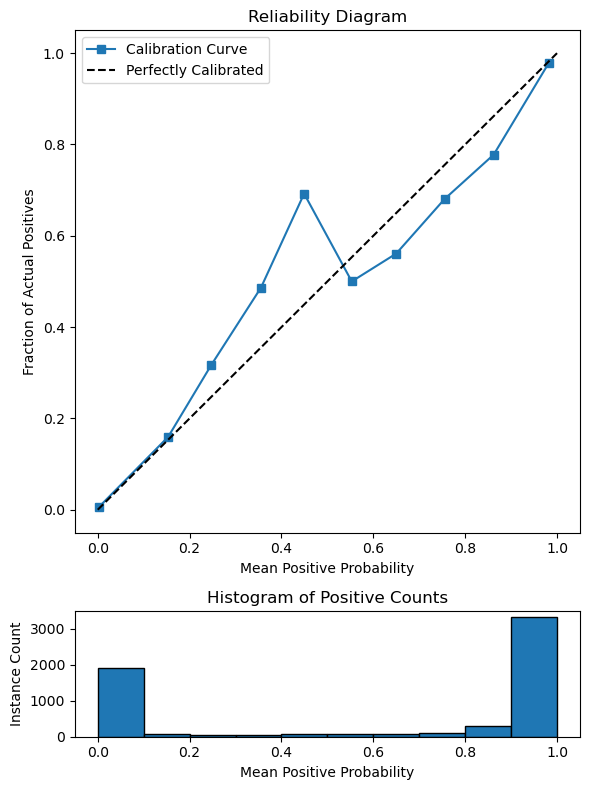

In [231]:
##################################################################################
## TEST CODE                                                                    ##
## Note: More hidden tests will be used. You should create more tests yourself. ##
##################################################################################

def _test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case !!!")

##################################################################################

training, testing = train_test_split(data, test_size=0.3, random_state=42)

BN = BayesNet(G)

BN.learn_outcome_space(data)
BN.learn_parameters(training, alpha=1)
print("*** BAYES NET ***")
reliability_plot(BN, testing, 'BC', 'No')

NB = NaiveBayes()
NB.learn_outcome_space(data)
NB.learn_structure(training, 'BC')
NB.learn_parameters(training, alpha=1)
print("*** NAÏVE BAYES ***")
reliability_plot(NB, testing, 'BC', 'No')

TN = TANet()
TN.learn_outcome_space(data)
TN.learn_structure(training, 'BC')
TN.learn_parameters(training, alpha=1)
print("*** TANet ***")
reliability_plot(TN, testing, 'BC', 'No')

## [5 Marks] Task 12 - The Expected Calibration Error (ECE)

This task computes a probabilistic classifier's Expected Calibration Error (ECE). The ECE will be useful in providing a numerical score for the calibration quality of a given model.

The ECE measures the average discrepancy between predicted probabilities and the actual outcomes. ECE is computed by partitioning the predictions into bins, calculating the absolute difference between the average predicted probability and the actual fraction of positive instances in each bin, and then averaging these differences, weighted by the number of samples in each bin. A lower ECE indicates better calibration, meaning the predicted probabilities more accurately reflect the true likelihood of the outcomes.

The formula for the Expected Calibration Error (ECE) is:

$ \text{ECE} = \sum_{i=1}^{b} \frac{|B_i|}{n} \cdot |\text{acc}(B_i) - \text{conf}(B_i)| $

where:
- $b$ is the number of bins.
- $|B_i|$ is the number of samples in bin $i$.
- $n$ is the total number of samples.
- $\text{acc}(B_i)$ is the observed frequency of the positive class in bin $i$.
- $\text{conf}(B_i)$ is the average predicted positive probability in bin $i$.

In other words, for each bin, the ECE calculates the absolute difference between the average predicted probability and the actual fraction of positives, multiplies this difference by the proportion of samples in that bin, and sums these values across all bins to get the final ECE.

In [239]:
## Develop your code for bin_pos_prob(model, data, class_var, pos_label, bins) in this cell

def ECE(model, data, class_var, pos_label, bins=10):
    '''
    Arguments:
        model:      A model object (Naïve Bayes, Bayes Net or TAN)
        data:       A Pandas dataframe object
        class_var:  A binary variable identifier
        pos_label:  The positive label of class_var
        bins:       The number of bins
    Returns:
        Returns the Expected Calibration Error (ECE)
    '''        
    ece = 0.0
    B, acc, conf = bin_pos_prob(model, data, class_var, pos_label, bins)

    for i in range(bins):
        ece += (B[i] / len(data)) * abs(acc[i] - conf[i])
  
    return ece

In [240]:
##################################################################################
## TEST CODE                                                                    ##
## Note: More hidden tests will be used. You should create more tests yourself. ##
##################################################################################

def _test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case !!!")

##################################################################################

training, testing = train_test_split(data, test_size=0.3, random_state=42)

BN = BayesNet(G)

BN.learn_outcome_space(data)
BN.learn_parameters(training, alpha=1)
ece = ECE(BN, testing, 'BC', 'No')
_test(abs(ece-0.0085) < 0.001)

NB = NaiveBayes()
NB.learn_outcome_space(data)
NB.learn_structure(data, 'BC')
NB.learn_parameters(training, alpha=1)
ece = ECE(NB, testing, 'BC', 'No')
_test(abs(ece-0.0591) < 0.001)

TN = TANet()
TN.learn_outcome_space(data)
TN.learn_structure(data, 'BC')
TN.learn_parameters(training, alpha=1)
ece = ECE(TN, testing, 'BC', 'No')
_test(abs(ece-0.0160) < 0.001)

Passed test case
Passed test case
Passed test case


## [20 Marks] Task 13 - Report

Write a report (**with less than 500 words**) summarising your findings in this assignment. Your report should address the following:

a. Make a summary and discussion of the experimental results. You can analyse your results from different aspects such as accuracy, calibration runtime, coding complexity and independence assumptions.

b. Discuss the time and memory complexity of the implemented models.

Use Markdown and Latex to write your report in the Jupyter Notebook. If you want, develop some plots using Matplotlib to illustrate your results. Be mindful of the maximum number of words. Please be concise and objective.

---
Write your report in one or more cells here.

---